In [1]:
import json
import networkx as nx

In [2]:
SHAKESPEARE = None
with open('play_details.json') as f:
    SHAKESPEARE = json.load(f)
    
assert SHAKESPEARE, "Failed to load JSON. Check path to file exists."

In [3]:
all_plays = []
for entry in SHAKESPEARE.keys():
    all_plays.append(nx.read_gpickle(f'output/{entry}.gpickle'))

assert len(all_plays) == 12, "Failed to load pickles. Check paths to files exist."

# Identify key characters

In [4]:
from collections import Counter

In [5]:
these_measures = {
        'degree': nx.degree_centrality,               #fraction of nodes a given node is connected to (# of unique exchanges the character has)
        'betweenness': nx.betweenness_centrality,     #sum of the fraction of shortest paths passing through a given node (how much of a "broker" the character is)
        'closeness': nx.closeness_centrality,         #reciprocal of the average shortest path distance from a given node to all other nodes (nearness to all other characters)
        'cluster_coeff': nx.clustering,               #fraction of actual triangles through a given node over all possible triangles (how likely nodes are to form tightly knit groups a.k.a. cliques)
        'eigen_centrality': nx.eigenvector_centrality #centrality of a given node based on the centrality of its neighbors (importance of a character based on importance of the characters it speaks with)
    }
for this_play in all_plays:
    print(this_play.name.title())
    counter_top_5 = Counter()
    for this_name, this_funct in these_measures.items():
        these_vals = this_funct(this_play)
        nx.set_node_attributes(this_play, these_vals, name=this_name)
        top_5 = [k for k,v in sorted(these_vals.items(), key=lambda item: item[1], reverse=True)][:5]
        print(this_name.title(), top_5)
        counter_top_5.update(top_5)
#     print("\t",this_play.name.title(), counter_top_5.most_common(5),'\n')
    print('\n')

Romeo
Degree ['Capulet', 'Romeo', 'Benvolio', 'Prince', 'Friar Lawrence']
Betweenness ['Benvolio', 'Romeo', 'Capulet', 'Nurse', 'First Watch']
Closeness ['Capulet', 'Benvolio', 'Romeo', 'Nurse', 'Friar Lawrence']
Cluster_Coeff ['Gregory', 'Abram', 'Lady Montague', 'Second Servant', 'Friar John']
Eigen_Centrality ['Capulet', 'Romeo', 'Benvolio', 'Friar Lawrence', 'Juliet']


Othello
Degree ['Cassio', 'Othello', 'Iago', 'Duke', 'Desdemona']
Betweenness ['Othello', 'Cassio', 'Duke', 'Montano', 'Desdemona']
Closeness ['Othello', 'Cassio', 'Iago', 'Desdemona', 'Duke']
Cluster_Coeff ['Sailor', 'Second Gentleman', 'Third Gentleman', 'Herald', 'Gentlemen']
Eigen_Centrality ['Cassio', 'Othello', 'Iago', 'Desdemona', 'Emilia']


Hamlet
Degree ['Hamlet', 'King', 'Horatio', 'Laertes', 'Queen']
Betweenness ['Hamlet', 'King', 'Horatio', 'Laertes', 'Polonius']
Closeness ['Hamlet', 'King', 'Horatio', 'Queen', 'Marcellus']
Cluster_Coeff ['Barnardo', 'Francisco', 'Guildenstern', 'First Player', 'Prologu

> ### The lists above show the top 5 characters from each of the centrality measures. We can see the lists are similar but not exactly the same. This is seems to be especially true of the results for clustering coefficient, the results of the four other measures seem to be highly correlated.

> ### Before creating a final list of the top 5 most important characters in each play, let's evaluate how correlated the measures are with one another.

# Correlations
> ### We have the actual scores from the various centrality measures so we can certainly evaluate the results using Pearson's correlation coefficient. However, in subsequent steps we'll finalize our top 5 using a relative rank ordering of the characters so let's check Spearman's rank correlation coefficient as well.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [13]:
# let's see how correlated the various measures are
df = pd.DataFrame(columns=['presence','degree','betweenness','closeness','cluster_coeff','eigen_centrality'])

for this_play in all_plays:
    temp_df = pd.DataFrame.from_dict(this_play.nodes(data=True))
    temp_df = temp_df[1].apply(pd.Series)
    
    df = df.append(temp_df) 

df.drop(columns='presence', inplace=True)

cmap = sns.color_palette("Spectral", as_cmap=True)

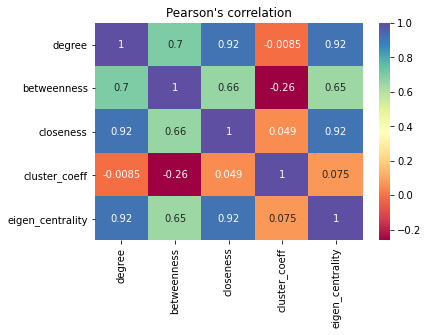

In [18]:
pearson = df.corr('pearson')
sns.heatmap(pearson, annot=True, cmap=cmap);
plt.title("Pearson's correlation");

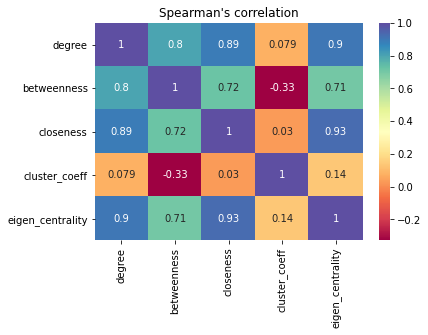

In [16]:
spearman = df.corr('spearman')
sns.heatmap(spearman, annot=True, cmap=cmap)
plt.title("Spearman's correlation");

> ### Both Pearson's and Spearman's correlations produce roughly similar results here. The heatmap colors are generally consistent between the two plots with the biggest differences between the entries for clustering coefficient and betweenness.

> ### Keep: clustering coefficient (it may not change any results but it does provide different information from the rest), eigen_centrality, betweenness

> ### Exclude: degree (it's redudant with all other measures and we don't expect it to reflect true importance of characters), 

# Top 5 based on betweenness, eigenvector centrality, and clustering coefficient

In [39]:
#any difference in results between using all measures & subset of measures?

select_measures = ['degree', 'betweenness', 'closeness', 'eigen_centrality'] #'degree','betweenness','closeness','cluster_coeff','eigen_centrality'

for this_play in all_plays:
    counter_top_5 = Counter()
    for this_name in select_measures:
        these_vals = nx.get_node_attributes(this_play, this_name)
        top_5 = [k for k,v in sorted(these_vals.items(), key=lambda item: item[1], reverse=True)][:5]
        counter_top_5.update(top_5)
    print(this_play.name.title(), counter_top_5.most_common(5),'\n')

Romeo [('Capulet', 4), ('Romeo', 4), ('Benvolio', 4), ('Friar Lawrence', 3), ('Nurse', 2)] 

Othello [('Cassio', 4), ('Othello', 4), ('Desdemona', 4), ('Iago', 3), ('Duke', 3)] 

Hamlet [('Hamlet', 4), ('King', 4), ('Horatio', 3), ('Laertes', 3), ('Queen', 3)] 

Caesar [('Brutus', 4), ('Cassius', 4), ('Antony', 4), ('Caesar', 4), ('Cinna', 3)] 

Macbeth [('Macbeth', 4), ('Malcolm', 4), ('Banquo', 4), ('Ross', 3), ('First Witch', 2)] 

Midsummer [('Theseus', 4), ('Demetrius', 4), ('Bottom', 4), ('Puck', 3), ('Lysander', 2)] 

Tempest [('Prospero', 4), ('Alonso', 4), ('Sebastian', 4), ('Gonzalo', 3), ('Ariel', 3)] 

Lear [('Lear', 4), ('Edmund', 4), ('Edgar', 4), ('Goneril', 3), ('Kent', 3)] 

Ado [('Benedick', 4), ('Leonato', 4), ('Claudio', 4), ('Dogberry', 3), ('Don Pedro', 3)] 

Merchant [('Portia', 4), ('Bassanio', 4), ('Shylock', 4), ('Lorenzo', 4), ('Gratiano', 4)] 

Shrew [('Petruchio', 4), ('Baptista', 3), ('Tranio', 3), ('Gremio', 3), ('Hortensio', 2)] 

Comedy [('Adriana', 4),

In [40]:
for this_play in all_plays:
    counter_top_5 = Counter()
    for this_name in these_measures.keys():
        these_vals = nx.get_node_attributes(this_play, this_name)
        top_5 = [k for k,v in sorted(these_vals.items(), key=lambda item: item[1], reverse=True)][:5]
        counter_top_5.update(top_5)
    print(this_play.name.title(), counter_top_5.most_common(5),'\n')

Romeo [('Capulet', 4), ('Romeo', 4), ('Benvolio', 4), ('Friar Lawrence', 3), ('Nurse', 2)] 

Othello [('Cassio', 4), ('Othello', 4), ('Desdemona', 4), ('Iago', 3), ('Duke', 3)] 

Hamlet [('Hamlet', 4), ('King', 4), ('Horatio', 3), ('Laertes', 3), ('Queen', 3)] 

Caesar [('Brutus', 4), ('Cassius', 4), ('Antony', 4), ('Caesar', 4), ('Cinna', 3)] 

Macbeth [('Macbeth', 4), ('Malcolm', 4), ('Banquo', 4), ('Ross', 3), ('First Witch', 2)] 

Midsummer [('Theseus', 4), ('Demetrius', 4), ('Bottom', 4), ('Puck', 3), ('Lysander', 2)] 

Tempest [('Prospero', 4), ('Alonso', 4), ('Sebastian', 4), ('Gonzalo', 3), ('Ariel', 3)] 

Lear [('Lear', 4), ('Edmund', 4), ('Edgar', 4), ('Goneril', 3), ('Kent', 3)] 

Ado [('Benedick', 4), ('Leonato', 4), ('Claudio', 4), ('Dogberry', 3), ('Don Pedro', 3)] 

Merchant [('Portia', 4), ('Bassanio', 4), ('Shylock', 4), ('Lorenzo', 4), ('Gratiano', 4)] 

Shrew [('Petruchio', 4), ('Baptista', 3), ('Tranio', 3), ('Gremio', 3), ('Hortensio', 2)] 

Comedy [('Adriana', 4),

# End